# **Projet de Processus de Poisson :** Thinning Algorithms for Simulating Point Processes

La méthode du **thinning** permet de simplifier la représentation spatiale de données en sélectionnant certains points vérifiant une condition donnée, tout en préservant les caractéristiques importantes de ces données. C'est une généralisation de la méthode d'acceptation/rejet souvent utilisée pour générer des variables aléatoires. La méthode du thinning permet de créer un processus de Poisson non homogène en sélectionnant judicieusement des points à partir d'un processus de Poisson homogène.

In [1]:
! pip install -U Cython numpy
! pip install hawkeslib

  Using cached hawkeslib-0.2.2.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for numdifftools>=0.9 from https://files.pythonhosted.org/packages/a3/5c/37cd5db8c465db2664b2219410b8bc7743da6edb1b616b5d13008bd7cac2/numdifftools-0.9.41-py2.py3-none-any.whl.metadata
  Using cached numdifftools-0.9.41-py2.py3-none-any.whl.metadata (39 kB)
Using cached numdifftools-0.9.41-py2.py3-none-any.whl (100 kB)
  Running setup.py clean for hawkeslib
Failed to build hawkeslib


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [60 lines of output]
  C:\Users\lisec\anaconda3\Lib\site-packages\setuptools\config\setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
  !!
  
          ********************************************************************************
          The license_file parameter is deprecated, use license_files instead.
  
          This deprecation is overdue, please update your project and remove deprecated
          calls to avoid build errors in the future.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    parsed = self.parsers.get(option_name, lambda x: x)(value)
  C:\Users\lisec\anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are depre

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import math
import pandas as pd
from scipy.stats import kstest
import statsmodels as sm
from datetime import datetime
from hawkeslib import UnivariateExpHawkesProcess as UVHP

ModuleNotFoundError: No module named 'hawkeslib'

## **Processus de comptage et processus ponctuel**

Pour commencer, nous définissons dans cette partie les processus de comptage et les processus ponctuels. En effet, ces deux derniers sont utilisés pour définir les processus de Poissons et de Hawkes, qui nous intéressent dans ce projet.

**Définition:** Le processus N(t) de comptage compte le nombre d'événements qui arrivent dans l'intervalle de temps $[0,t]$. Il  est défini par le processus $\{N(t) ; t \geq 0\}$ et vérifie les propriétés suivantes : 
- $\forall t \geq 0$, $N(t)$ est constant par morceaux et à valeurs dans $\mathbb{N}$ ;
- $t \mapsto N(t) \text{ est croissante}$ ;
- $\forall 0<a<b$, $N(b)-N(a)$ représente le nombre d'événements arrivant dans l'intervalle de temps $]a,b]$.


**Définition:** Un processus ponctuel sur $\mathbb{R}^+$ est un sous-ensemble aléatoire et dénombrable de $\mathbb{R}^+$ où chaque point correspond au moment d'occurance d'événement. Il est aussi défini comme l'intersection entre $\mathbb{R}^+$ et la séquence croissante des temps auxquels les événements se produisent. Cette séquence est aussi appelée comme l'ensemble des temps d'arrivée et notée $0 < T_1 < T_2 < ... < T_n < ...$ avec  $(T_n)_n \in \mathbb{R}^+$ 

**Lien entre processus ponctuel $(T_n)_n$ et processus de comptage $(N_t)_t$:**   
$ \forall n \in \mathbb{N}^+$ et pour tout ($t_1$, $t_2$, ..., $t_n$) dans $\mathbb{R}^+$ : 

$ \{T_1 \leq t_1, T_2 \leq t_2, \ldots, T_n \leq t_n \} = \{ N_{t_1} \geq 1, N_{t_2} \geq 2, \ldots, N_{t_n} \geq n \}$

Il est donc équivalent de définir un processus ponctuel grâce aux temps d'arrivée ou grâce au processus de comptage. On choisira pour la suite de le définir avec $(N_t)_t$.

***Propriété :*** Un processus de ponctuel N est à *accroissements indépendants* si le nombre de points entre intervalles disjoints est indépendant. Autrement dit, $\forall n \in \mathbb{N}^*$, $\forall \quad  0<t_1<t_2<...<t_n$, les variables aléatoires $N_{t_1}-N_0, N_{t_2}-N_{t_1}, ..., N_{t_n}-N_{t_{n-1}}$ sont indépendantes.



***Propriété:*** Un processus ponctuel est à *accroissements stationnaires* si la distribution du nombre de points de tout intervalle de temps dépend uniquement de la longueur de cet intervalle. Autrement dit, $\forall s \geq 0$, le nombre de points dans l'intervalle $(t,s+t]$ soit $N_{t+s}-N_{t}$ a la même distribution $\forall t$.

## **Processus de poisson homogène sur $\mathbb{R}_+$**

Dans cette partie, nous donnons quelques définitions et propriétés des processus de Poisson homogènes avant de les simuler !

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson homogène d'intensité $\lambda > 0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

***Proposition:*** Le nombre de points dans un intervalle de longueur t d'un processus de poisson homogène suit une loi de Poisson de paramètre $\lambda t$. 
$$ \mathbb{P}\{N(t + s) - N(s) = n \} = e^{-\lambda t}\frac{{(\lambda t)^n }}{{n!}}$$

***Proposition:*** Les temps d'arrivée d'un processus de poisson homogène sont distribués suivant une variable aléatoire qui suit une loi exponentielle de paramètre $\lambda$.

***Proposition:***  $\mathbb{E}(N_t)=Var(N_t)= \lambda t$

Ainsi, un processus de Poisson homogène se caractérise par l'indépendance et la stationnarité de ses événements et par son intensité $\lambda$ constante.

### *Algo 1: Simulation d'un processus de Poisson Homogène avec un taux λ sur [0,T]*

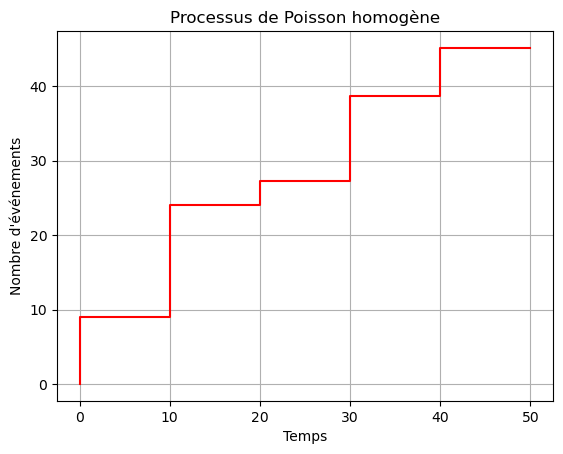

In [16]:
lamb = 0.1
T = 50#steps

def Process_homogène(lamb,T):
    val=[0]
    t=0
    while True :
        u=npr.uniform(0,1)
        w=-1/lamb * np.log(u)## w~exp(lamb)
        #print(w)
        t=t+w
        #print(times)
        if t > T : 
            return val, len(val)
        else : 
            val.append(t)

#Applications
P,n= Process_homogène(lamb,T)
times=np.linspace(0,T,n) #création intervalle de temps

#Affichage
plt.step(times, P,color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson homogène')
plt.grid(True)
plt.show()

## **Processus de poisson inhomogène sur $\mathbb{R}_+$**

Dans cette partie, nous définissions désormais les processus de poisson inhomogène avant d'également les simuler !

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson inhomogène avec pour intensité la fonction localement intégrable $\lambda (t) > 0$, $t>0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda(t) h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

La fonction $\Lambda$ : $t \mapsto \int_{0}^{t} \lambda (s) \,ds $ est appelée l'intensité cumulée du processus de Poisson inhomogène. 

La définition précédente est identique à celle d'un processus de Poisson homogène à la différence que l'intensité n'est maintenant plus constante, mais dépend du temps $t$.

***Proposition :*** Un processus de Poisson inhomogène N d'intensité la fonction $\lambda (t)$ suit une loi de Poisson de paramètre $\int_{0}^{t}\lambda (s) \,ds$ : 

$$\mathbb{P}(N(t)=n) = \frac{\exp^{-\int_{0}^{t}\lambda (s) \,ds} (\int_{0}^{t}\lambda (s) \,ds)^n} {n!} $$

***Proposition:***  $\mathbb{E}(N_t)=Var(N_t)=\Lambda(t)$

Ainsi, à la différence d'un processus de poisson homogène, un processus inhomogène a une intensité $\lambda(t)$ qui varie avec le temps mais conserve l'indépendance et la stationnarité de ces événements.

### *Algo 2: Simulation d'un processus de Poisson Inhomogène avec une fonction intensité bornée sur [0,T]*

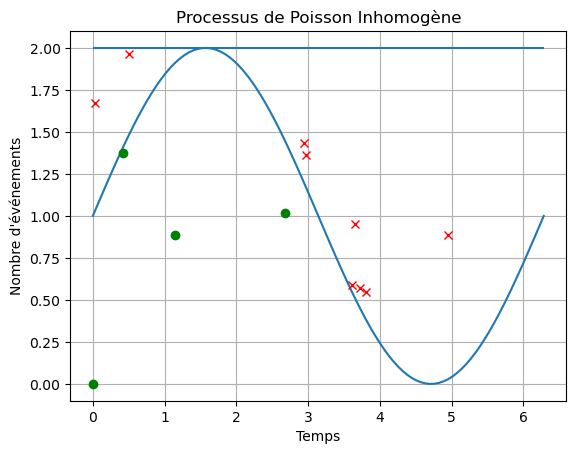

In [4]:
lamb = 0.4
Tmax = 2*np.pi
times=np.linspace(0,Tmax, 10)

#### fonction densité ####
def lambd(t) :
    return 1+np.sin(t)

#### fonction qui calcule le sup ####
def sup(fonction, debut=0, fin=Tmax, pas=0.01):
    t = debut
    sup = fonction(debut)
    while t <= fin: 
        if fonction(t) > sup:
            sup = fonction(t)
        t += pas
    return sup

 
#### fonction qui génère le process ####
def Process_inhomogène(lamb,Tmax):
    T=[0] ; S=[0]
    T_R=[] ; R=[]
    t=0 ; s=0
    lamb_max= sup(lamb)
    
    while s<Tmax :
        u=npr.uniform(0,1)
        w=-math.log(u)/lamb_max    # w~exp(lamb_max)
        s=s+w
        D=npr.uniform(0,1)
        if D <= lamb(s)/lamb_max : #condition d'acception des temps tau par rapport au sup de notre fonction lambda 
            t=s
            T.append(t)            #tau accepté
            S.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau acceptés
        else :
            T_R.append(s)                                                                                                                                       #Lise refusée
            R.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau refusés
            t=s                    #pour bien s'assurer qu'on ne dépasse pas tmax même dans ce cas où on incrément pas les tau acceptés 
    if t<=Tmax :
        return T,S,T_R,R
    else : 
        return T[:-1],S[:-1],T_R[:-1],R[:-1] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax
        
                                        
     
x=np.linspace(0,Tmax,100)
#Application de la fonction rate: 
plt.plot(x, lambd(x))
plt.hlines(2,0,Tmax)



#Applications de la fonction de simulation/thinning
T,D,T_R,R= Process_inhomogène(lambd,Tmax)

plt.plot(T,D, "o",color='green')
plt.plot(T_R,R, "x",color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson Inhomogène')
plt.grid(True)
plt.show()

## **Processus de Hawkes sur $\mathbb{R}_+$**

**Définition :** Un processus est dit simple si 
$$ P(N({t}) = 0 \text{ ou } 1 \text{ pour tout } t) = 1 $$


**Définition** : (Hawkes, 1971) Un processus de Hawkes est un processus ponctuel univariant simple N(t) qui vérifie : 
- N(t) = 0 ;
- λ(t) est processus stochastique continu à gauche, donné par l'intégrale de Stieltjes :
$$ \lambda(t) = \mu + \int_{0}^{t} \alpha \exp(-\beta (t-s)) \, dN(s) = \mu + \sum_{k: t_k < t} \alpha \exp^{-\beta (t-s)} $$
avec $\mu>0$ et $0 < \alpha < \beta$ ;
- λ(t) est l'intensité stochastique du processus de ponctuel telle que :  
$$ P(N(t+h) - N(t) = 1 \,|\, \mathcal{F}_{t^-}^N) = \lambda(t)h + o(h) $$ 
- Le processus ponctuel est ordonné tel que : 
$$ P(N(t+h) - N(t) \geq 2 \,|\, \mathcal{F}_{t^-}^N) = o(h) $$

Ce processus est dit Hawkes univariant avec une décroissance exponentielle sur $[0,\inf)$.




La différence entre un processus de Hawkes et un processus de Poisson homogène ou inhomogène est la dépendance temporelle entre ses événements. Les événements du présent d'un tel processus influent sur les événements du futur. L'intensité du processus est conditionnée par son passé.

### Algo 3: Simulation of a Univariate Hawkes Poisson with Exponential Kernel

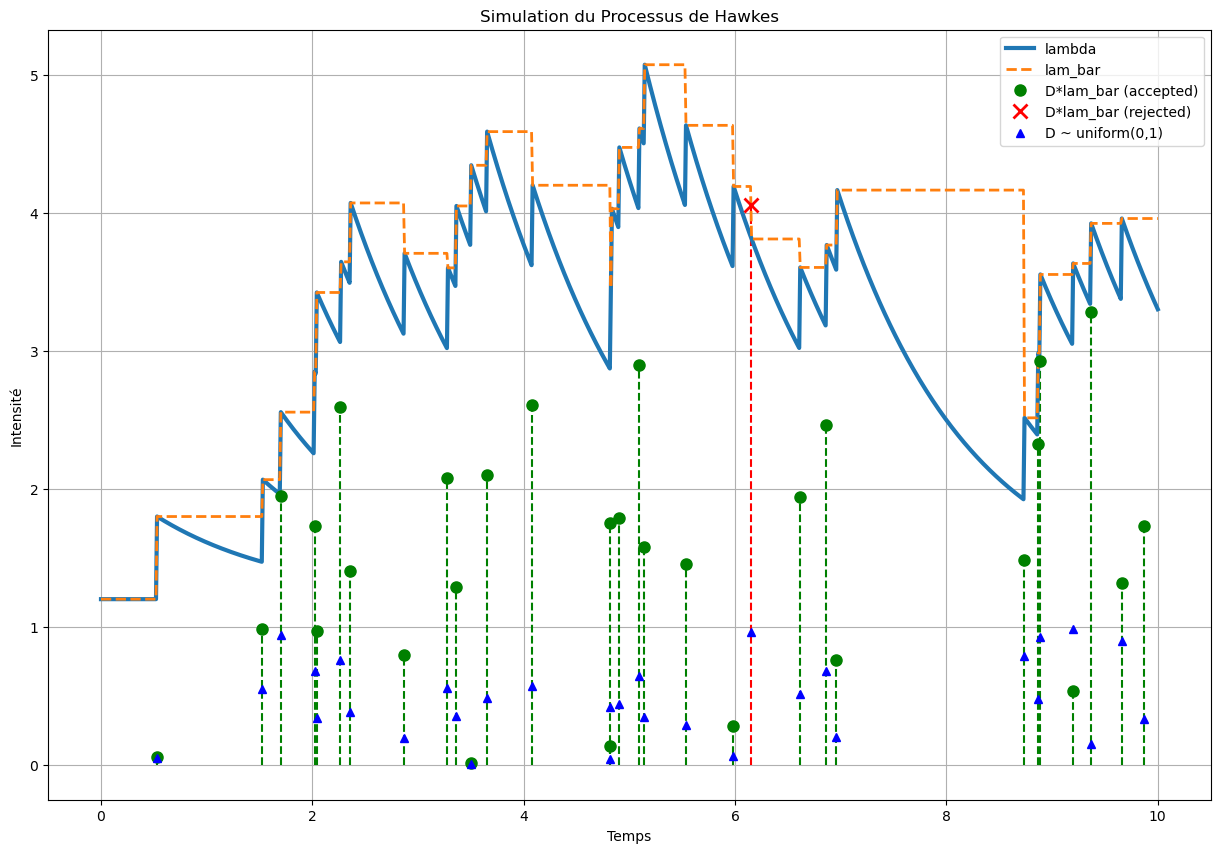

In [5]:
# fonction densité ####
def lam(su,times,mu=1.2,alpha=0.6,beta=0.8) :
    if times == []:
        return mu
    else : 
        return mu + np.sum(alpha * np.exp(-beta * (su - np.array(times))))    


def Hawkes_Process(mu, alpha, beta, Tmax):
    T = []  # Pour stocker les tau
    S = [] # Pour stocker le critère d'accepttaion du tau
    s = 0  # Initialize s
    T_R = [] ; R = []
    L = [] ; I = []
    while s < Tmax:
        if T == []:
            lambda_bar = mu
            L.append(lambda_bar)
        u = np.random.uniform(0, 1)
        w = -np.log(u)/lambda_bar
        s += w
        D = np.random.uniform(0, 1)
        I.append(D)
        l=lam(s,T)
        if D * lambda_bar <= l:
            t=s
            T.append(t)              #tau accepté
            S.append(D*lambda_bar)   #valeur de D*lamdba_max pour les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T))))
        else :
            T_R.append(s)                                                                                                                                       #Lise refusée
            R.append(D*lambda_bar)   #valeur de D*lamdba_max pour les tau refusés
            t=s                    #pour bien s'assurer qu'on ne dépasse pas tmax même dans ce cas où on incrément pas les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T))))
    plt.show()
    if t<=Tmax :
        return T,S,T_R,R,I
    else :
        return T[:-1],S[:-1],T_R[:-1],R[:-1], I[:-2] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax

# Application:
mu = 1.2
alpha = 0.6
beta = 0.8
Tmax = 10
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax)
#Application de la fonction rate:

times=np.linspace(0,Tmax,1000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1


fig = plt.figure(figsize = (15, 10))


count=0
for i in TH:
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--')
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--')
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")
TH2=TH+TH_R
TH2=sorted(TH2)

plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

## **Cas pratique : Application de l'algo de Hawkes aux données financières du CAC40**

In [8]:
#Chargement des données
CAC40 = pd.read_csv('^FCHI.csv')
display(CAC40)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-15,7443.379883,7455.629883,7397.859863,7418.209961,7418.209961,48638700
1,2023-05-16,7394.850098,7427.569824,7377.810059,7406.009766,7406.009766,61261800
2,2023-05-17,7378.830078,7422.580078,7354.540039,7399.439941,7399.439941,57783800
3,2023-05-18,7440.750000,7481.779785,7426.390137,7446.890137,7446.890137,59991600
4,2023-05-19,7469.779785,7523.560059,7463.959961,7491.959961,7491.959961,67973200
...,...,...,...,...,...,...,...
251,2024-05-08,8093.620117,8157.479980,8089.279785,8131.410156,8131.410156,53988400
252,2024-05-09,8123.919922,8191.919922,8114.879883,8187.649902,8187.649902,39071500
253,2024-05-10,8232.650391,8259.190430,8211.200195,8219.139648,8219.139648,57091000
254,2024-05-13,8211.070313,8223.809570,8186.770020,8209.280273,8209.280273,48113100


In [9]:
## regarder date d'ouverture marché et de fermeture 
## abs(close-open) / close > seuil (1%) #le rendement permet d'avoir une mesure à peu près homogène
## on compte le nombre de fois où ça arrive et a chaque fois que ca arrive on le stocke
## faire repartition dans le vecteur temps avec histogramme  et le vecteur est censé représenté une loi exponentielle

### Processus de Comptage

[6, 14, 15, 24, 38, 42, 48, 53, 66, 73, 88, 90, 100, 106, 108, 109, 119, 127, 131, 149, 164, 170, 176, 181, 210, 234, 246]


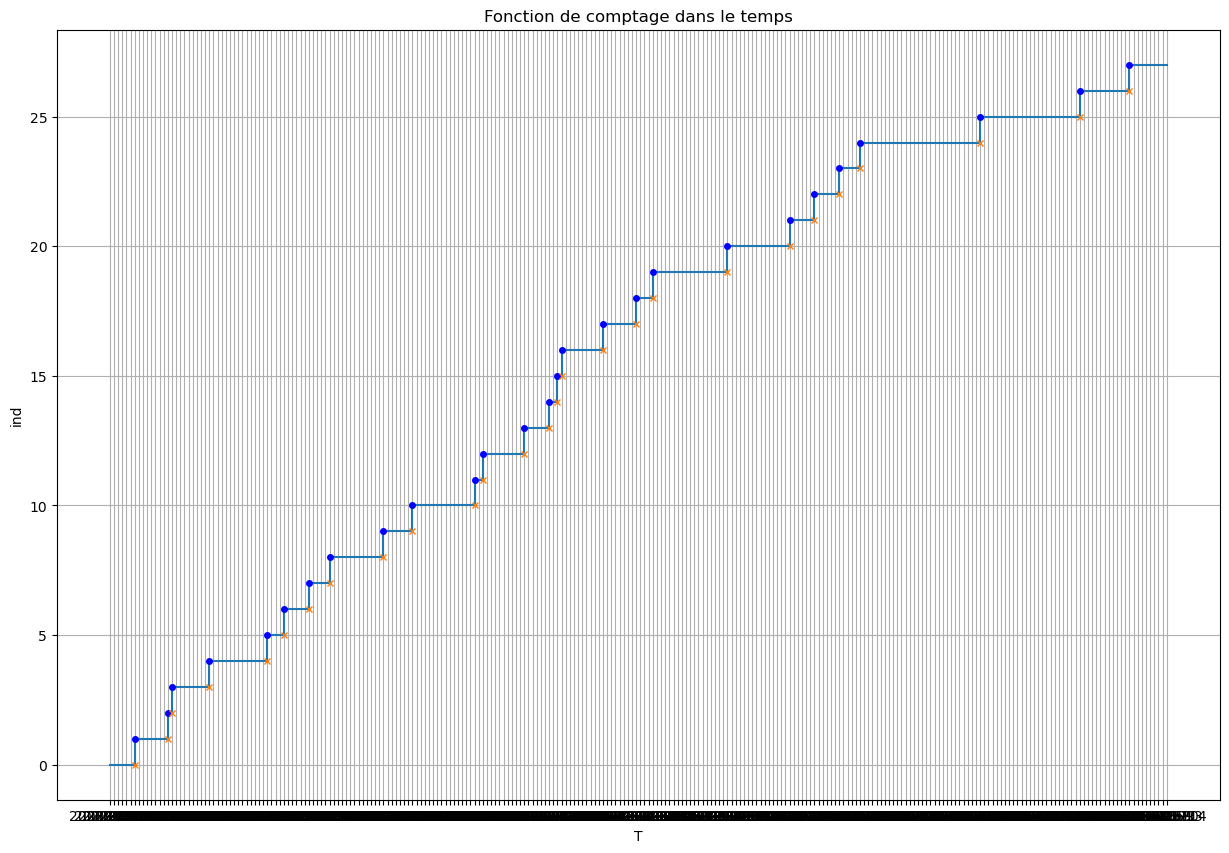

[datetime.date(2023, 5, 15), datetime.date(2023, 5, 16), datetime.date(2023, 5, 17), datetime.date(2023, 5, 18), datetime.date(2023, 5, 19), datetime.date(2023, 5, 22), datetime.date(2023, 5, 23), datetime.date(2023, 5, 24), datetime.date(2023, 5, 25), datetime.date(2023, 5, 26), datetime.date(2023, 5, 29), datetime.date(2023, 5, 30), datetime.date(2023, 5, 31), datetime.date(2023, 6, 1), datetime.date(2023, 6, 2), datetime.date(2023, 6, 5), datetime.date(2023, 6, 6), datetime.date(2023, 6, 7), datetime.date(2023, 6, 8), datetime.date(2023, 6, 9), datetime.date(2023, 6, 12), datetime.date(2023, 6, 13), datetime.date(2023, 6, 14), datetime.date(2023, 6, 15), datetime.date(2023, 6, 16), datetime.date(2023, 6, 19), datetime.date(2023, 6, 20), datetime.date(2023, 6, 21), datetime.date(2023, 6, 22), datetime.date(2023, 6, 23), datetime.date(2023, 6, 26), datetime.date(2023, 6, 27), datetime.date(2023, 6, 28), datetime.date(2023, 6, 29), datetime.date(2023, 6, 30), datetime.date(2023, 7, 3),

In [13]:
#display(CAC40.iloc[:,1]) 2eme colonne 
ferme = CAC40.iloc[:,4]
ouvert = CAC40.iloc[:,1]
date = CAC40.iloc[:,0]

T=[]
T_last=[]
Val=[]
ind_seuil=[]
ind_1=[]; ind_2=[]
ind=0
a=0
for i in range(len(CAC40)): 
    if np.abs(ferme[i] - ouvert[i]) / ferme[i] > 0.01 :
        T.append(i) #à chaque fois que l'expression dépasse le seuil on stocke la date 
        Val.append(np.abs(ferme[i] - ouvert[i]) / ferme[i]) #on stocke également la valeur du taux
        ind+=1
        ind_seuil.append(ind) #on stocke l'index
        ind_1.append(ind)
        ind_2.append(ind-1)
    else :
        ind_seuil.append(ind)
        
fig = plt.figure(figsize = (15, 10))
plt.plot(date, ind_seuil, drawstyle='steps-post')
plt.plot(T, ind_1, "o", color="blue", markersize=4)
plt.plot(T, ind_2, "x", markersize=4)
print(T)
plt.xlabel('T')
plt.ylabel('ind')
plt.title('Fonction de comptage dans le temps')
plt.grid(True)
plt.show()


dates = [datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in date]
print(dates)


### Test de Kolmogorov Smirnoff Lilifors
On veut désormais tester s'il existe un paramètre tel que le processus de comptage ci-dessus peut être assimilé à un processus de poisson homogène. Ainsi on teste si les inter-sauts qui suivent une loi exponentielle dont on ne connaît pas le paramètre. 

Ainsi on doit faire un test de Kolmogorov Smirnoff corrigé par Lilifors sur ces inter-sauts.

In [15]:
#print(T)
inter_saut=[]
for i in range(0,len(T)-1):
    inter_saut.append(T[i+1]-T[i])
    
print(inter_saut)
#Test d'ajustement (Kolmogorov Smirnoff Lilifors)
ksstat, pvalue = sm.stats.diagnostic.lilliefors(inter_saut,"exp",'approx')
print("La stat de test est :",ksstat)
print("La p_value du test est ", pvalue)

alpha=0.05
if pvalue > alpha:
    result = 'Inter-Saut Exponentiel => Processus de Poisson Homogène'
else:
    result = 'Inter-Saut non exponentiel => Pas un Processus de Poisson Homogène'
print(f'Lilliefors: {result:>21s}')

[8, 1, 9, 14, 4, 6, 5, 13, 7, 15, 2, 10, 6, 2, 1, 10, 8, 4, 18, 15, 6, 6, 5, 29, 24, 12]


AttributeError: module 'statsmodels' has no attribute 'stats'

### HAWKES POUR CAC40 OMG POG

In [ ]:
plt.figure(figsize=(15,2))
plt.ylim([-5, 5])
plt.yticks([])
_ = plt.plot(T, np.random.rand(len(T)), 'k.')

In [ ]:
print(type(T))
from hawkeslib import UnivariateExpHawkesProcess as UVHP
uv = UVHP()
uv.fit(np.array(T))


In [ ]:
# verify that the unconditional mean makes sense
mu, alpha, theta = uv.get_params()

N_approx = mu * td[-1] / (1 - alpha)

print(N_approx)
print(len(td))

In [ ]:
from hawkeslib import BayesianUVExpHawkesProcess as BUVHP

buv = BUVHP(mu_hyp=(1., 10.), alpha_hyp=(1., 1.), theta_hyp=(1., 10.))
trace = buv.sample_posterior(T, T=T[-1], n_samp=50000)

## ***BIBLIOGRAPHIE :***
- *Thinning Algorithms for Simulating Point Processes*, Yuanda Chen
- *Poisson processes and application to reliability theory and actuarial science*, Mélisande ALBERT
- *Cours sur les processus de poissons*, Université de Rennes, Jérémy Bettinger & Simon Viel
- *Processus de Poisson homogènes - Application à des données génomiques*, Mélisande ALBERT & Nicolas OGOREK
